In [1]:
import numpy as np
import pandas as pd
from sklearn.neighbors import BallTree
import matplotlib.pyplot as plt

# multivariate multi-step encoder-decoder lstm example
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

In [2]:
X_train = np.load('X_train_surge.npz')
Y_train = pd.read_csv('Y_train_surge.csv')
X_test = np.load('X_test_surge.npz')

In [3]:
surge_train = np.array(Y_train)[:,1:]

In [4]:
def surge_prediction_metric(dataframe_y_true, dataframe_y_pred):
    weights = np.linspace(1, 0.1, 10)[np.newaxis]
    surge1_columns = [
        'surge1_t0', 'surge1_t1', 'surge1_t2', 'surge1_t3', 'surge1_t4',
        'surge1_t5', 'surge1_t6', 'surge1_t7', 'surge1_t8', 'surge1_t9' ]
    surge2_columns = [
        'surge2_t0', 'surge2_t1', 'surge2_t2', 'surge2_t3', 'surge2_t4',
        'surge2_t5', 'surge2_t6', 'surge2_t7', 'surge2_t8', 'surge2_t9' ]
    surge1_score = (weights * (dataframe_y_true[surge1_columns].values - dataframe_y_pred[surge1_columns].values)**2).mean()
    surge2_score = (weights * (dataframe_y_true[surge2_columns].values - dataframe_y_pred[surge2_columns].values)**2).mean()

    return surge1_score + surge2_score

In [5]:
def time_elapsed_hour(time_1, time_2):
    return (time_2-time_1)/(3600)

In [6]:
slp_train = X_train['slp']
t_slp_train = X_train['t_slp']
t_surge1_input_train = X_train['t_surge1_input']
t_surge2_input_train = X_train['t_surge2_input']
surge1_input_train = X_train['surge1_input']
surge2_input_train = X_train['surge2_input']
t_surge1_output_train = X_train['t_surge1_output']
t_surge2_output_train = X_train['t_surge2_output']

In [7]:
def format_t(data):
    new_set = set()
    for j in data:
        for i in j:
            new_set.add(i)
    new_set=sorted(list(new_set))
    return new_set

t_slp_train_set = format_t(t_slp_train)

In [8]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [ ]:
j = 0
for entry in slp_train:
    #if time_elapsed_hour(t_slp_train[j][-1], t_slp_train[j+1][0])<4*3600:
       # continue
    i = 0
    k = 0
    dataset = np.zeros([14, 1681])
    for image in entry:
        if i%3==0:
            dataset[k]=np.ndarray.flatten(image)
            k += 1
        i += 1
    n_steps_in, n_steps_out = 3, 2
    # covert into input/output
    X_new, y_new = split_sequences(dataset, n_steps_in, n_steps_out)   
    if j == 0:
        X = np.array(X_new)
        y = np.array(y_new)
    else:
        X = np.concatenate([X, X_new], axis=0)            
        y = np.concatenate([y, y_new], axis=0) 
    j+=1
    if j>2000:
        break
    print(j)

In [35]:
i = 0
length = 20000 #len(t_slp_train_set)-1
for j in range(length):
    if time_elapsed_hour(t_slp_train_set[j], t_slp_train_set[j+1])>3.5:
        dataset = slp_train_set[i:j+1]
        n_steps_in, n_steps_out = 12, 5
        # covert into input/output
        X_new, y_new = split_sequences(dataset, n_steps_in, n_steps_out)   
        if i == 0:
            X = np.array(X_new)
            y = np.array(y_new)
        else:
            X = np.concatenate([X, X_new], axis=0) 
            y = np.concatenate([y, y_new], axis=0) 
        i = j + 1
        print(j)
    else:
        continue 
    

(20010, 3, 1681)

In [95]:
# demonstrate prediction
x_input = X[0:3]
#x_input = x_input.reshape((1, n_steps_in, n_features))
yhat = model.predict(x_input, verbose=1)
print(yhat)

1/1 [==============================] - 15s 15s/step
[[[102868.61  102938.19  103002.75  ... 101588.93  101703.055 101704.32 ]
  [102951.92  102998.484 103041.92  ... 101667.45  101767.25  101740.75 ]
  [102955.64  103000.336 103042.52  ... 101671.51  101766.945 101743.39 ]
  [102955.12  103000.47  103043.04  ... 101671.195 101767.234 101743.82 ]
  [102955.21  103000.52  103043.    ... 101671.25  101767.266 101743.78 ]]

 [[102835.58  102933.055 102993.51  ... 101568.3   101702.086 101696.19 ]
  [102919.34  102994.055 103032.195 ... 101647.016 101766.91  101732.734]
  [102922.8   102995.49  103032.67  ... 101650.79  101766.37  101735.16 ]
  [102922.266 102995.64  103033.195 ... 101650.48  101766.64  101735.586]
  [102922.336 102995.68  103033.15  ... 101650.52  101766.67  101735.54 ]]

 [[102805.42  102925.73  102989.625 ... 101547.75  101698.88  101690.73 ]
  [102890.07  102987.7   103028.64  ... 101627.4   101764.98  101727.58 ]
  [102893.42  102988.96  103029.016 ... 101631.06  10176

In [ ]:
for j in range(3):
    plt.imshow(x_input[0][j].reshape(41,41))
    plt.show()

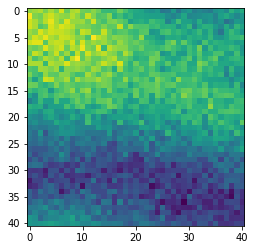

In [101]:
plt.imshow(yhat[0][4].reshape(41,41))

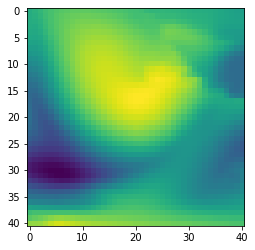

In [102]:
plt.imshow(y[0][4].reshape(41,41))